In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Create a list of sets of N random numbers
N = 3
inputs = (10 * torch.rand((10000,N),dtype=torch.float32) - 5).cuda()
outputs = inputs ** 2

In [54]:
outputs.device

device(type='cuda', index=0)

In [55]:
inputs[0]

tensor([-0.8261,  4.6494,  4.8795], device='cuda:0')

In [56]:
outputs[0]

tensor([ 0.6824, 21.6166, 23.8090], device='cuda:0')

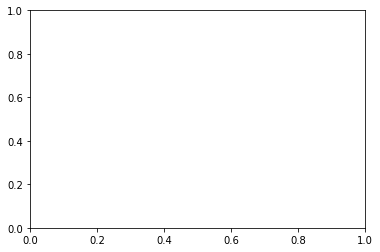

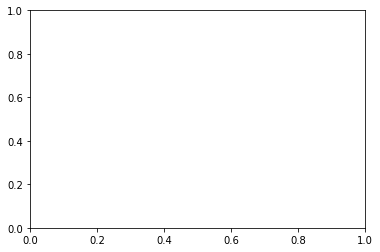

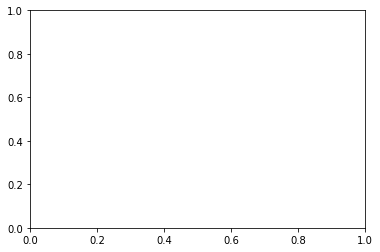

In [57]:
# set up graph for loss curve, accuracy curve
fig_loss, ax_loss = plt.subplots()
fig_accu, ax_accu = plt.subplots()
fig_accupts, ax_accupts = plt.subplots()
loss_vals = []
loss_epochs = []
test_loss_vals = []
test_loss_epochs = []
accu_vals = []
accu_epochs = []
accupts_vals = []
accupts_epochs = []

# create a test set
# test_inputs = (10 * torch.rand((1000,N),dtype=torch.float32) - 5).cuda()
test_inputs = torch.randn((1000,N),dtype=torch.float32).cuda()
test_outputs = test_inputs ** 2

In [58]:
def weight_bias(plot_num):
    #updates plot number in case of multiple function calls in the same cell
    count = plot_num
    #attains weights of first layer then divides into components
    Weights1 = model.state_dict()['0.weight'].tolist()
    Weights1_A = [i[0] for i in Weights1]
    Weights1_B = [i[1] for i in Weights1]
    Weights1_C = [i[2] for i in Weights1]
    #attains bias of the first layer
    Bias1 = model.state_dict()['0.bias'].tolist()
    #attains weights of second layer then divides into components
    Weights2 = model.state_dict()['2.weight'].tolist()
    Weights2_A = [i[0] for i in Weights2]
    Weights2_B = [i[1] for i in Weights2]
    Weights2_C = [i[2] for i in Weights2]
    #attains bias of the second layer
    Bias2 = model.state_dict()['2.bias'].tolist()
    plt.figure(count)
    count += 1
    #I included the code for scatterplots as comments in case those are desired down the road
    #plt.scatter(Weights1_A, list(range(len(Weights1_A))), color = 'b')
    plt.hist(Weights1_A, [-1, -.75, -.5, -.25, 0, .25, .5, .75, 1], color = 'b')
    plt.xlabel("Weights1_A")
    plt.ylabel("# of instances")
    plt.figure(count)
    count += 1
    #plt.scatter(Weights1_B, list(range(len(Weights1_B))), color = 'g')
    plt.hist(Weights1_B, [-1, -.75, -.5, -.25, 0, .25, .5, .75, 1], color = 'g')
    plt.xlabel("Weights1_B")
    plt.ylabel("# of instances")
    plt.figure(count)
    count += 1
    #plt.scatter(Weights1_C, list(range(len(Weights1_C))), color = 'r')
    plt.hist(Weights1_C, [-1, -.75, -.5, -.25, 0, .25, .5, .75, 1], color = 'r')
    plt.xlabel("Weights1_C")
    plt.ylabel("# of instances")
    plt.figure(count)
    count += 1
    #plt.scatter(Bias1, list(range(len(Bias1))), color = 'c')
    plt.hist(Bias1, [-1.5, -1, -.5, 0, .5, 1, 1.5], color = 'c')
    plt.xlabel("Bias1")
    plt.ylabel("# of instances")
    plt.figure(count)
    count += 1
    #There are only 3 points for weights and bias in the 2nd layer so I left them as scatterplots
    plt.scatter(Weights2_A, list(range(len(Weights2_A))), color = 'm')
    plt.xlabel("Weights2_A")
    plt.ylabel("# of index")
    plt.figure(count)
    count += 1
    plt.scatter(Weights2_B, list(range(len(Weights2_B))), color = 'y')
    plt.xlabel("Weights2_B")
    plt.ylabel("# of index")
    plt.figure(count)
    count += 1
    plt.scatter(Weights2_C, list(range(len(Weights2_C))), color = 'k')
    plt.xlabel("Weights2_C")
    plt.ylabel("# of index")
    plt.figure(count)
    count += 1
    plt.scatter(Bias2, list(range(len(Bias2))), color = 'hotpink')
    plt.xlabel("Bias2")
    plt.ylabel("# of index")
    #returns a dictionary with all the saved weight and bias data
    return {"Weights1":Weights1, "Weights1_A":Weights1_A,"Weights1_B":Weights1_B,"Weights1_C":Weights1_C,"Bias1":Bias1,"Weights2":Weights2, "Weights2_A":Weights2_A,"Weights2_B":Weights2_B,"Weights2_C":Weights2_C,"Bias2":Bias2}


In [59]:
# Check what proportion of the predictions falls within 0.01 absolute accuracy or 1% relative accuracy
def test_data(prediction, actual):
    "Output 1 if prediction is accurate enough and 0 otherwise"
    abs_err = abs(prediction-actual)
    rel_err = abs_err / actual
    if (abs_err < 0.01 or rel_err < 0.01):
        return 1
    else: return 0

v_test_data = np.vectorize(test_data) # This makes a vector function and avoids a for loop to improve performance

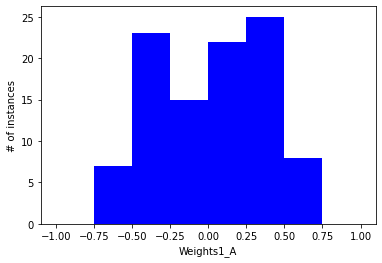

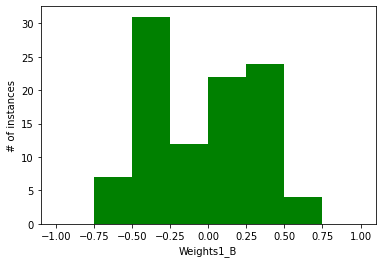

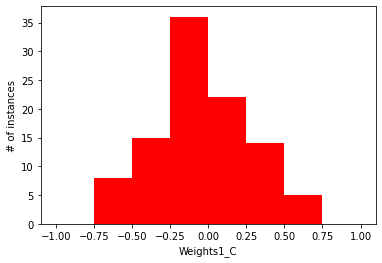

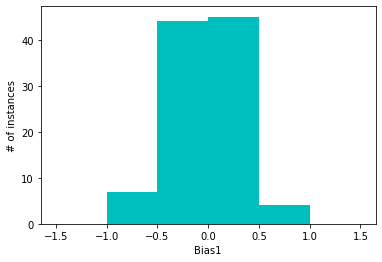

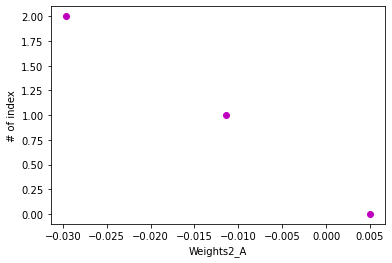

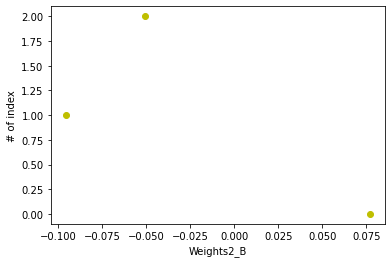

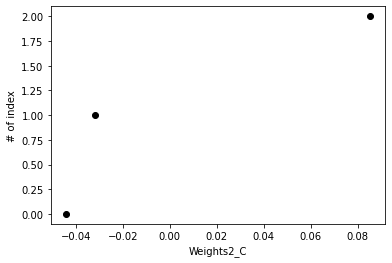

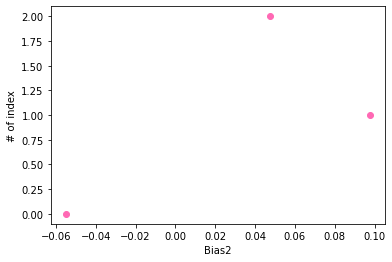

In [60]:
import pprint

# Create a simple neural network
hidden_nodes = 100
model = torch.nn.Sequential(
    torch.nn.Linear(inputs.shape[1],hidden_nodes),
    torch.nn.ReLU(),
    # torch.nn.Linear(hidden_nodes,hidden_nodes),
    # torch.nn.ReLU(),
    torch.nn.Linear(hidden_nodes,outputs.shape[1])
)
model.cuda()

#print('Weights and bias values before training.')
#for label in model.state_dict().keys():
    #x = model.state_dict()[label]
    # print('\n{}: '.format(label))
    #pprint.pprint(x)

#print('\nCheck the neural network output before training:')
#with torch.no_grad():
    #model.eval()
    #test = torch.tensor([0.1, 0.2, 0.3]).cuda()
    #prediction = model(test)
    # print('input: {}, output: {}'.format(test,prediction))

initial_wb_dict = weight_bias(1)

=>Starting 1/500 epochs.
=>Starting 11/500 epochs.
=>Starting 21/500 epochs.
=>Starting 31/500 epochs.
=>Starting 41/500 epochs.
=>Starting 51/500 epochs.
=>Starting 61/500 epochs.
=>Starting 71/500 epochs.
=>Starting 81/500 epochs.
=>Starting 91/500 epochs.
=>Starting 101/500 epochs.
=>Starting 111/500 epochs.
=>Starting 121/500 epochs.
=>Starting 131/500 epochs.
=>Starting 141/500 epochs.
=>Starting 151/500 epochs.
=>Starting 161/500 epochs.
=>Starting 171/500 epochs.
=>Starting 181/500 epochs.
=>Starting 191/500 epochs.
=>Starting 201/500 epochs.
=>Starting 211/500 epochs.
=>Starting 221/500 epochs.
=>Starting 231/500 epochs.
=>Starting 241/500 epochs.
=>Starting 251/500 epochs.
=>Starting 261/500 epochs.
=>Starting 271/500 epochs.
=>Starting 281/500 epochs.
=>Starting 291/500 epochs.
=>Starting 301/500 epochs.
=>Starting 311/500 epochs.
=>Starting 321/500 epochs.
=>Starting 331/500 epochs.
=>Starting 341/500 epochs.
=>Starting 351/500 epochs.
=>Starting 361/500 epochs.
=>Starting 3

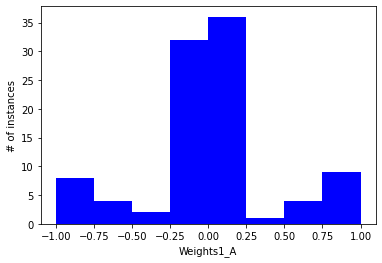

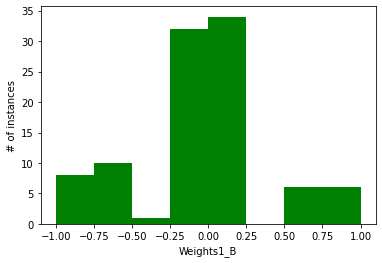

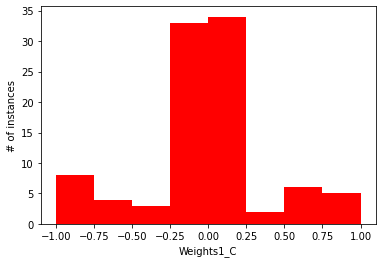

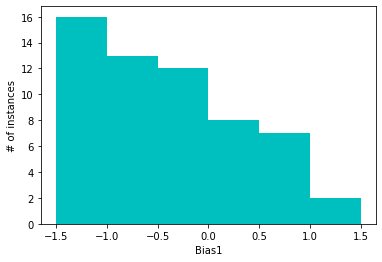

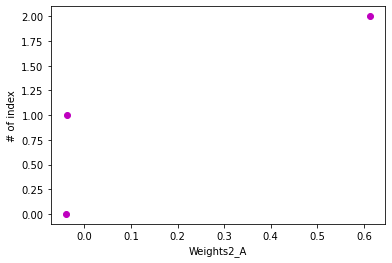

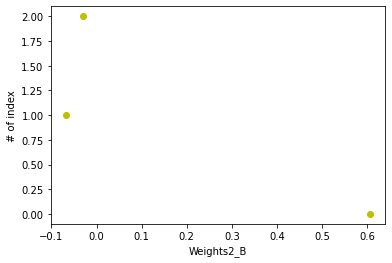

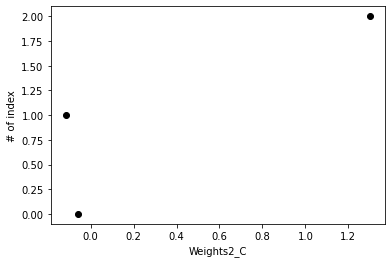

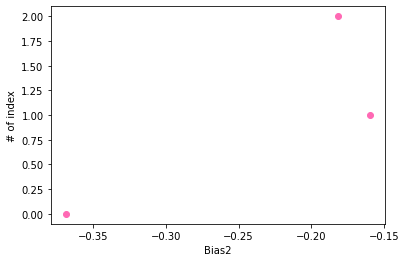

In [61]:
import math

# Get ready to train
model.train()

# Break the list up into smaller batches for more efficient training
numMiniBatch = int(math.floor(inputs.shape[0]/100.))
inputMiniBatches = inputs.chunk(numMiniBatch)
outputMiniBatches = outputs.chunk(numMiniBatch)

# Train the neural network
lossFunc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

n_epochs = 500

loss_vals = []
loss_epochs = []
test_loss_vals = []
test_loss_epochs = []
accu_vals = []
accu_epochs = []
accupts_vals = []
accupts_epochs = []

for epoch in range(n_epochs):
    # Print something every 10 epochs of training
    # Plot accuracy every 10 epochs
    if epoch%10 == 0:
        print('=>Starting {}/{} epochs.'.format(epoch+1,n_epochs))
        
        with torch.no_grad():
            model.eval()
            prediction_temp = model(test_inputs)
            total_num = torch.numel(test_inputs)
            score_temp = v_test_data(prediction_temp.cpu().detach().numpy(), test_outputs.cpu().detach().numpy())
            accu_vals = np.append(accu_vals, np.sum(score_temp) / total_num)
            accu_epochs = np.append(accu_epochs, epoch)
            accurate_points = np.delete(test_inputs.cpu().detach().numpy(), np.where((score_temp * test_inputs.cpu().detach().numpy()).flatten()==0))
            accupts_vals = np.append(accupts_vals, accurate_points)
            accupts_epochs = np.append(accupts_epochs, np.full((1,accurate_points.size),epoch))
            
        model.train()
            
    for minibatch in range(numMiniBatch):
        prediction = model(inputMiniBatches[minibatch])
        loss = lossFunc(prediction,outputMiniBatches[minibatch])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Plot two points on the loss graph for each epoch, one for testing and one for training.
    with torch.no_grad():
        model.eval()
        total_prediction_temp = model(inputs)
        total_loss_temp = lossFunc(total_prediction_temp, outputs).item()
        test_total_prediction_temp = model(test_inputs)
        test_total_loss_temp = lossFunc(test_total_prediction_temp, test_outputs).item()
        loss_vals = np.append(loss_vals, total_loss_temp)
        loss_epochs = np.append(loss_epochs, epoch)
        test_loss_vals = np.append(test_loss_vals, test_total_loss_temp)
        test_loss_epochs = np.append(test_loss_epochs, epoch)
    model.train()
        
# ax_loss.legend() # I didn't find an easy way to add a legend for this particular graph

ax_accu.plot(accu_epochs, accu_vals, 'b-')
ax_accu.set_xlabel('Epochs')
ax_accu.set_ylabel('Accuracy')
                                  
ax_accupts.scatter(accupts_epochs, accupts_vals, c='b', s=1)
ax_accupts.set_xlabel('Epochs')
ax_accupts.set_ylabel('Inputs with Accurate Predictions')

ax_loss.plot(loss_epochs, loss_vals, 'b-', linewidth=1)
ax_loss.plot(test_loss_epochs, test_loss_vals, 'g-', linewidth=1)
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Total Loss')
ax_loss.set_yscale('log')
    
print ('Training done!')
final_wb_dict = weight_bias(1)

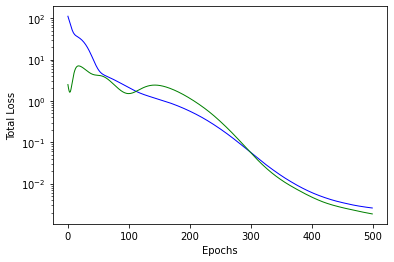

In [62]:
fig_loss

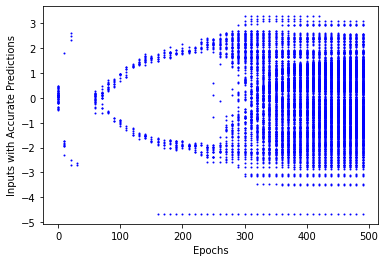

In [63]:
fig_accupts

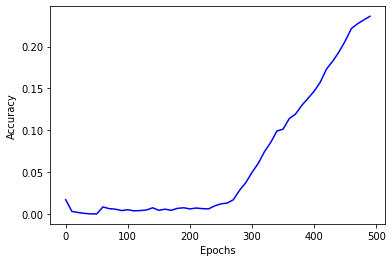

In [64]:
fig_accu

In [65]:
# fig_loss.savefig('loss.pdf')
# fig_accu.savefig('accu.pdf')
# fig_accupts.savefig('accupts.pdf')

In [ ]:
# test a single input, not very useful
with torch.no_grad():
    model.eval()
    test = torch.tensor([0.1, 0.2, 0.3]).cuda()
    prediction = model(test)
    print('input: {}, prediction: {}'.format(test,prediction))

In [ ]:
# Check out the output by running the model in evaluation
# make some residual plots

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()


# this can be easily modified to plot output vs. input directly
with torch.no_grad():
    model.eval()
    for input in test_inputs:
        prediction = model(input)
        actual = input ** 2
        residual = actual - prediction
        ax.plot(input[0].item(),residual[0].item(), 'bo', markersize=1)
        ax.set_xlabel('1st coordinate input')
        ax.set_ylabel('1st coordinate error')
        ax2.plot(input[1].item(),residual[1].item(), 'go', markersize=1)
        ax2.set_xlabel('2nd coordinate input')
        ax2.set_ylabel('2nd coordinate error')
        ax3.plot(input[2].item(),residual[2].item(), 'co', markersize=1)
        ax3.set_xlabel('3rd coordinate input')
        ax3.set_ylabel('3rd coordinate error')

In [ ]:
# fig.savefig('1st-1st.pdf')
# fig2.savefig('2nd-2nd.pdf')
# fig3.savefig('3rd-3rd.pdf')

In [ ]:
# I didn't find a way to get around having to .cpu() first before converting to a numpy array
scores = v_test_data(test_total_prediction.cpu().detach().numpy(), test_outputs.cpu().detach().numpy())

In [ ]:
# I realized that this actually treats the coordinates of the vectors as separate data points, so it's
# actually computing the proportion of accurate coordinates. To fix this I'll need to find the norm of the vectors
# and check accuracy on those. 
np.sum(scores) / torch.numel(test_inputs)

In [ ]:
# Work out the details
x0 = test[0].item()
x1 = test[1].item()
x2 = test[2].item()

print('Input to neural network:')
print('x0={:7.4f}, x1={:7.4f},x2={:7.4f}'.format(x0,x1,x2))

# Check the math by hand
A = model.state_dict()['0.weight'].tolist()
a = model.state_dict()['0.bias'].tolist()

sum0 = A[0][0]*x0+A[0][1]*x1+A[0][2]*x2+a[0]
sum1 = A[1][0]*x0+A[1][1]*x1+A[1][2]*x2+a[1]
sum2 = A[2][0]*x0+A[2][1]*x1+A[2][2]*x2+a[2]
print('\nSums for first layer:')
print('{:7.4f} = {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f}'.format(sum0,A[0][0],x0,A[0][1],x1,A[0][2],x2,a[0]))
print('{:7.4f} = {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f}'.format(sum1,A[1][0],x0,A[1][1],x1,A[1][2],x2,a[1]))
print('{:7.4f} = {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f}'.format(sum2,A[2][0],x0,A[2][1],x1,A[2][2],x2,a[2]))

y0 = max(sum0,0)
y1 = max(sum1,0)
y2 = max(sum2,0)
print('\nApplying the ReLU to the sums:')
print('y0 = {:7.4f} = ReLU({:7.4f})'.format(y0,sum0))
print('y1 = {:7.4f} = ReLU({:7.4f})'.format(y1,sum1))
print('y2 = {:7.4f} = ReLU({:7.4f})'.format(y2,sum2))

B = model.state_dict()['2.weight'].tolist()
b = model.state_dict()['2.bias'].tolist()

z0 = B[0][0]*y0+B[0][1]*y1+B[0][2]*y2+b[0]
z1 = B[1][0]*y0+B[1][1]*y1+B[1][2]*y2+b[1]
z2 = B[2][0]*y0+B[2][1]*y1+B[2][2]*y2+b[2]
print('\nCalculating the final output:')
print('z0 = {:7.4f} = {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f}'.format(z0,B[0][0],y0,B[0][1],y1,B[0][2],y2,b[0]))
print('z1 = {:7.4f} = {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f}'.format(z1,B[1][0],y0,B[1][1],y1,B[1][2],y2,b[1]))
print('z2 = {:7.4f} = {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f} * {:7.4f} + {:7.4f}'.format(z2,B[2][0],y0,B[2][1],y1,B[2][2],y2,b[2]))